In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2

# -------------------------
# 1. Dataset CIFAR-10
# -------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

class_names = ['avión', 'auto', 'pájaro', 'gato', 'ciervo',
               'perro', 'rana', 'caballo', 'barco', 'camión']

# -------------------------
# 2. Definición del bloque SE
# -------------------------
def se_block(input_tensor, ratio=16):
    """
    Implementa el bloque Squeeze-and-Excitation (SE).
    """
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    x = layers.Multiply()([input_tensor, se])
    return x, se

    """
    Implementa el bloque Squeeze-and-Excitation (SE).

    El paso 'Squeeze' usa GlobalAveragePooling2D para resumir espacialmente la información de
    los canales. El paso 'Excitation' usa dos capas densas para aprender las dependencias
    entre los canales, generando un vector de pesos de atención.
    """
# -------------------------
# 3. Definición del modelo CNN + SE (Mejorado)
# -------------------------
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="conv2d_1")(inputs)
x, se_weights_1 = se_block(x, ratio=8)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2d_2")(x)
x, se_weights_2 = se_block(x, ratio=8)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="conv2d_3")(x)
x, se_weights_3 = se_block(x, ratio=8)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# -------------------------
# 4. Entrenamiento
# -------------------------
print("🤖 Entrenando el modelo...")
history = model.fit(x_train, y_train, validation_split=0.1, epochs=50, batch_size=128)
print("✅ Entrenamiento completado.")

# -------------------------
# 5. Modelos para obtener los pesos de atención
# -------------------------
se_model_1 = models.Model(inputs=model.input, outputs=se_weights_1)
se_model_2 = models.Model(inputs=model.input, outputs=se_weights_2)
se_model_3 = models.Model(inputs=model.input, outputs=se_weights_3)



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
🤖 Entrenando el modelo...
Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3179 - loss: 1.8553 - val_accuracy: 0.5144 - val_loss: 1.3309
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5566 - loss: 1.2444 - val_accuracy: 0.6306 - val_loss: 1.0349
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6485 - loss: 1.0050 - val_accuracy: 0.6784 - val_loss: 0.9319
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7028 - loss: 0.8499 - val_accuracy: 0.7228 - val_loss: 0.8041
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7484 - loss: 0.7230 - val_accuracy: 0.7384 - val_loss: 0.7726
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7843 - loss: 0.6190 - val_accuracy: 0.7498 - val_loss: 0.7513
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8188 - loss: 0.5163 - val_accuracy: 0.7542 - val_loss: 0.7465
Epoch 8/50
352/35

In [2]:
# -------------------------
# 6. ANÁLISIS DE UNA IMAGEN INDIVIDUAL (con predicción de clase)
# -------------------------
def analyze_single_image_with_prediction(image_path, true_label_name):
    """
    Carga una imagen, la clasifica y muestra los pesos de atención junto
    con el resultado de la predicción.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError("No se pudo cargar la imagen. Verifique la ruta del archivo.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return

    resized_image = cv2.resize(image, (32, 32))
    input_image = np.expand_dims(resized_image, axis=0) / 255.0

    # 1. Obtener la predicción de la clase
    predictions = model.predict(input_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # 2. Obtener los pesos de atención
    se_output_1 = se_model_1.predict(input_image)[0].flatten()
    se_output_2 = se_model_2.predict(input_image)[0].flatten()
    se_output_3 = se_model_3.predict(input_image)[0].flatten()

    # 3. Mostrar el resultado y los gráficos
    print("\n--- Análisis de la imagen ---")
    print(f"Etiqueta Real: {true_label_name}")
    print(f"Clase Predicha: {predicted_class_name}")
    if true_label_name == predicted_class_name:
        print("✅ ¡La predicción es CORRECTA!")
    else:
        print("❌ La predicción es INCORRECTA.")

    plt.figure(figsize=(20, 6))

    # Subplot 1: Imagen Original
    plt.subplot(1, 4, 1)
    plt.imshow(resized_image)
    plt.title(f'Imagen de Entrada\nReal: {true_label_name}\nPredicha: {predicted_class_name}')
    plt.axis('off')

    # Subplot 2: Pesos de Atención SE (Bloque 1)
    plt.subplot(1, 4, 2)
    plt.bar(range(len(se_output_1)), se_output_1, color='skyblue')
    plt.title('Pesos SE (Bloque 1)')
    plt.xlabel('Canales')
    plt.ylabel('Importancia')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Subplot 3: Pesos de Atención SE (Bloque 2)
    plt.subplot(1, 4, 3)
    plt.bar(range(len(se_output_2)), se_output_2, color='lightgreen')
    plt.title('Pesos SE (Bloque 2)')
    plt.xlabel('Canales')
    plt.ylabel('Importancia')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Subplot 4: Pesos de Atención SE (Bloque 3)
    plt.subplot(1, 4, 4)
    plt.bar(range(len(se_output_3)), se_output_3, color='salmon')
    plt.title('Pesos SE (Bloque 3)')
    plt.xlabel('Canales')
    plt.ylabel('Importancia')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


🚀 Analizando una imagen externa con predicción...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step

--- Análisis de la imagen ---
Etiqueta Real: perro
Clase Predicha: perro
✅ ¡La predicción es CORRECTA!


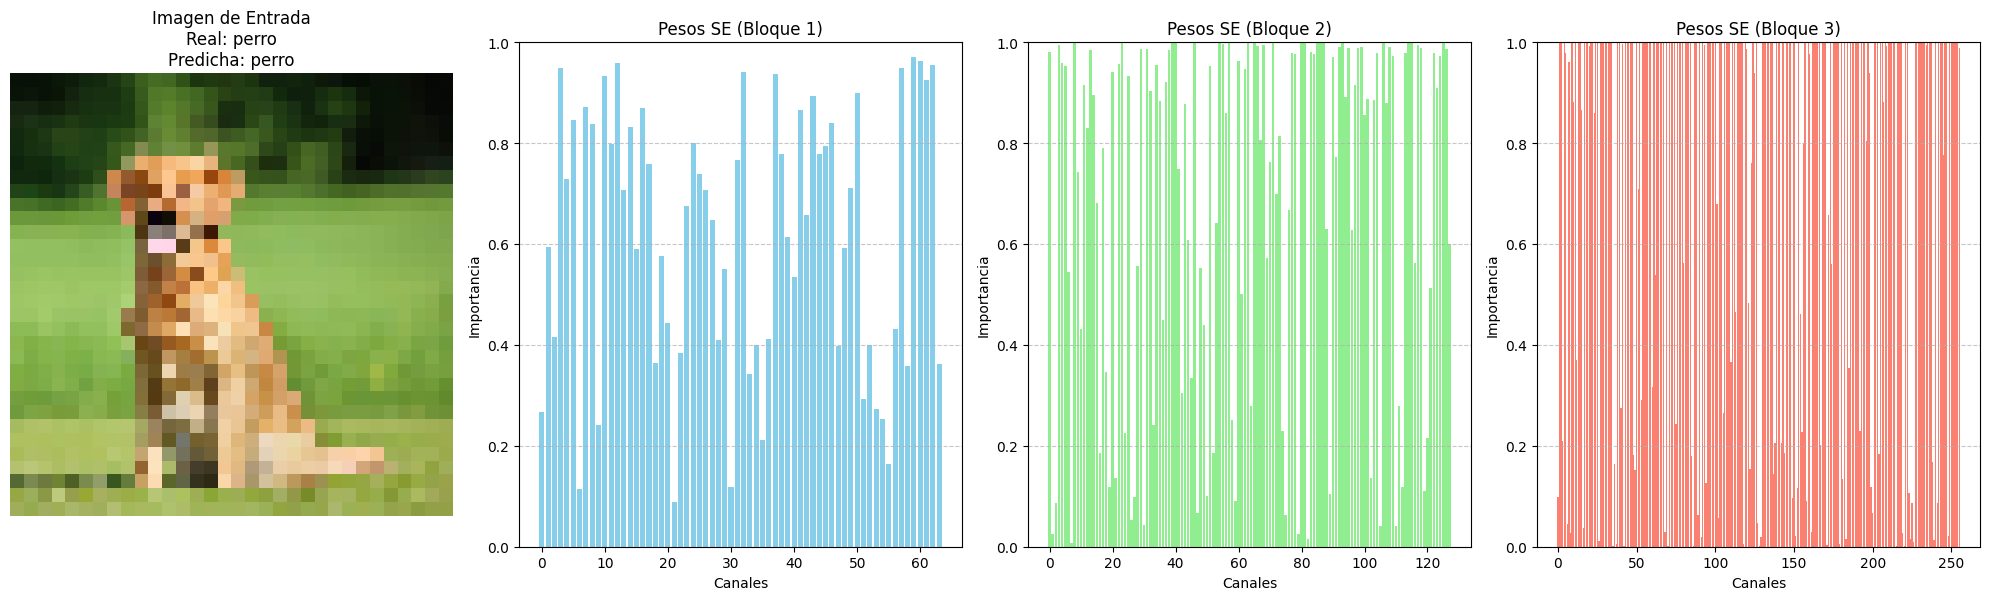

In [3]:
# -------------------------
# 7. EJECUTAR ANÁLISIS CON IMAGEN EXTERNA Y PREDICCIÓN
# -------------------------
print("🚀 Analizando una imagen externa con predicción...")
analyze_single_image_with_prediction('/content/perro.jpg', 'perro')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

--- Análisis de la imagen ---
Etiqueta Real: gato
Clase Predicha: gato
✅ ¡La predicción es CORRECTA!


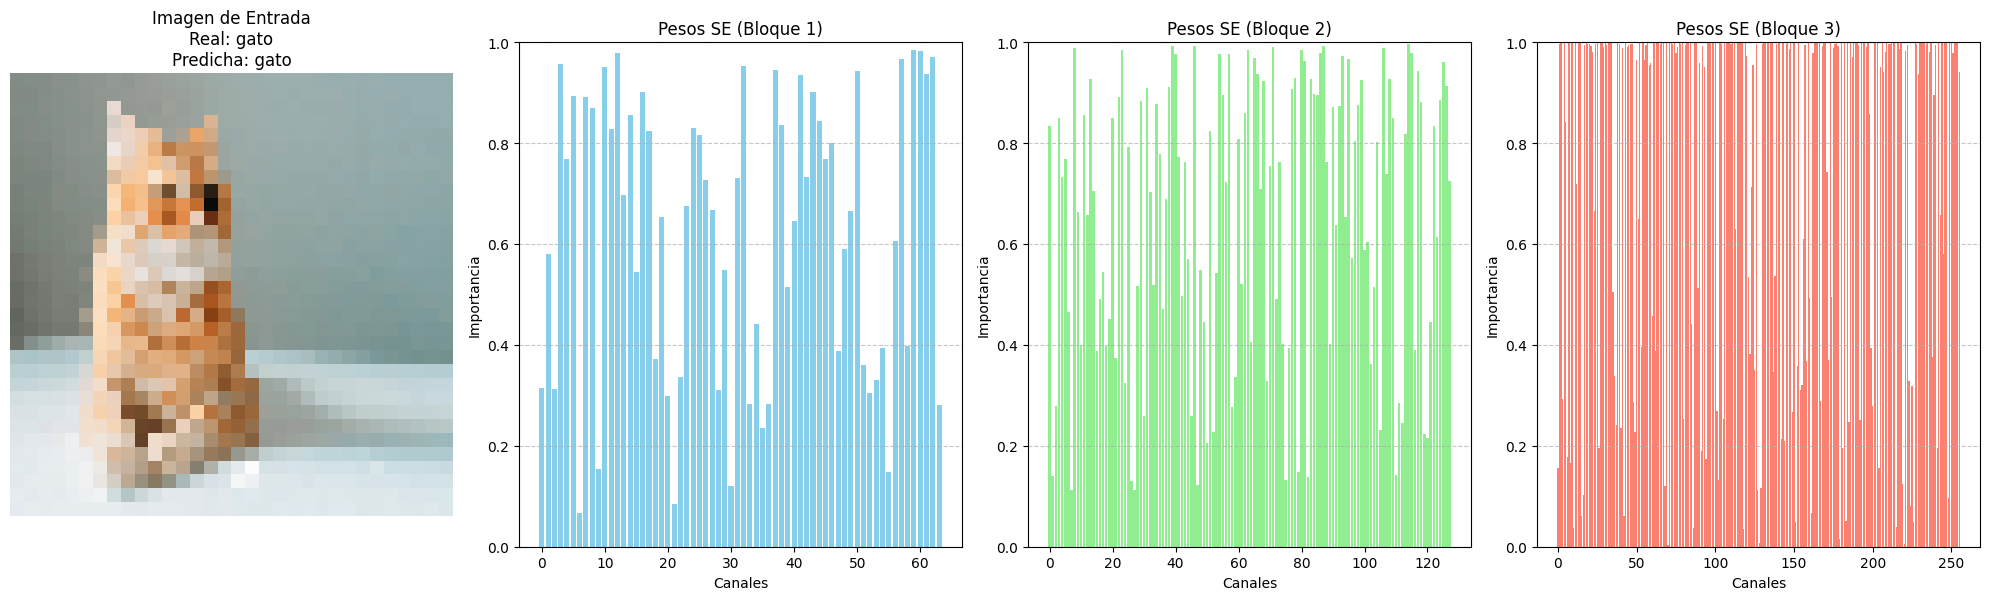

In [4]:
analyze_single_image_with_prediction('/content/gato.png', 'gato')

In [5]:
# -------------------------
# A. ANÁLISIS DETALLADO DE TODAS LAS CLASES
# -------------------------
def analyze_all_classes_detailed():
    """
    Muestra los patrones de atención promedio y la desviación estándar
    de los canales para cada una de las 10 clases.
    """

    for clase in range(10):
        imgs_clase = x_test[y_test.flatten() == clase][:100]
        attn_clase_1 = se_model_1.predict(imgs_clase)
        attn_clase_2 = se_model_2.predict(imgs_clase)
        attn_clase_3 = se_model_3.predict(imgs_clase)

        mean_attn_clase_1 = np.mean(attn_clase_1, axis=0).flatten()
        mean_attn_clase_2 = np.mean(attn_clase_2, axis=0).flatten()
        mean_attn_clase_3 = np.mean(attn_clase_3, axis=0).flatten()

        plt.figure(figsize=(20, 6))

        # Gráfico de Barras para Bloque 1
        plt.subplot(1, 3, 1)
        plt.bar(range(len(mean_attn_clase_1)), mean_attn_clase_1, color='skyblue')
        plt.title(f'Clase: {class_names[clase]} - Bloque 1')
        plt.xlabel('Canales de Características')
        plt.ylabel('Importancia SE (promedio)')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Gráfico de Barras para Bloque 2
        plt.subplot(1, 3, 2)
        plt.bar(range(len(mean_attn_clase_2)), mean_attn_clase_2, color='lightgreen')
        plt.title(f'Clase: {class_names[clase]} - Bloque 2')
        plt.xlabel('Canales de Características')
        plt.ylabel('Importancia SE (promedio)')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Gráfico de Barras para Bloque 3
        plt.subplot(1, 3, 3)
        plt.bar(range(len(mean_attn_clase_3)), mean_attn_clase_3, color='salmon')
        plt.title(f'Clase: {class_names[clase]} - Bloque 3')
        plt.xlabel('Canales de Características')
        plt.ylabel('Importancia SE (promedio)')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


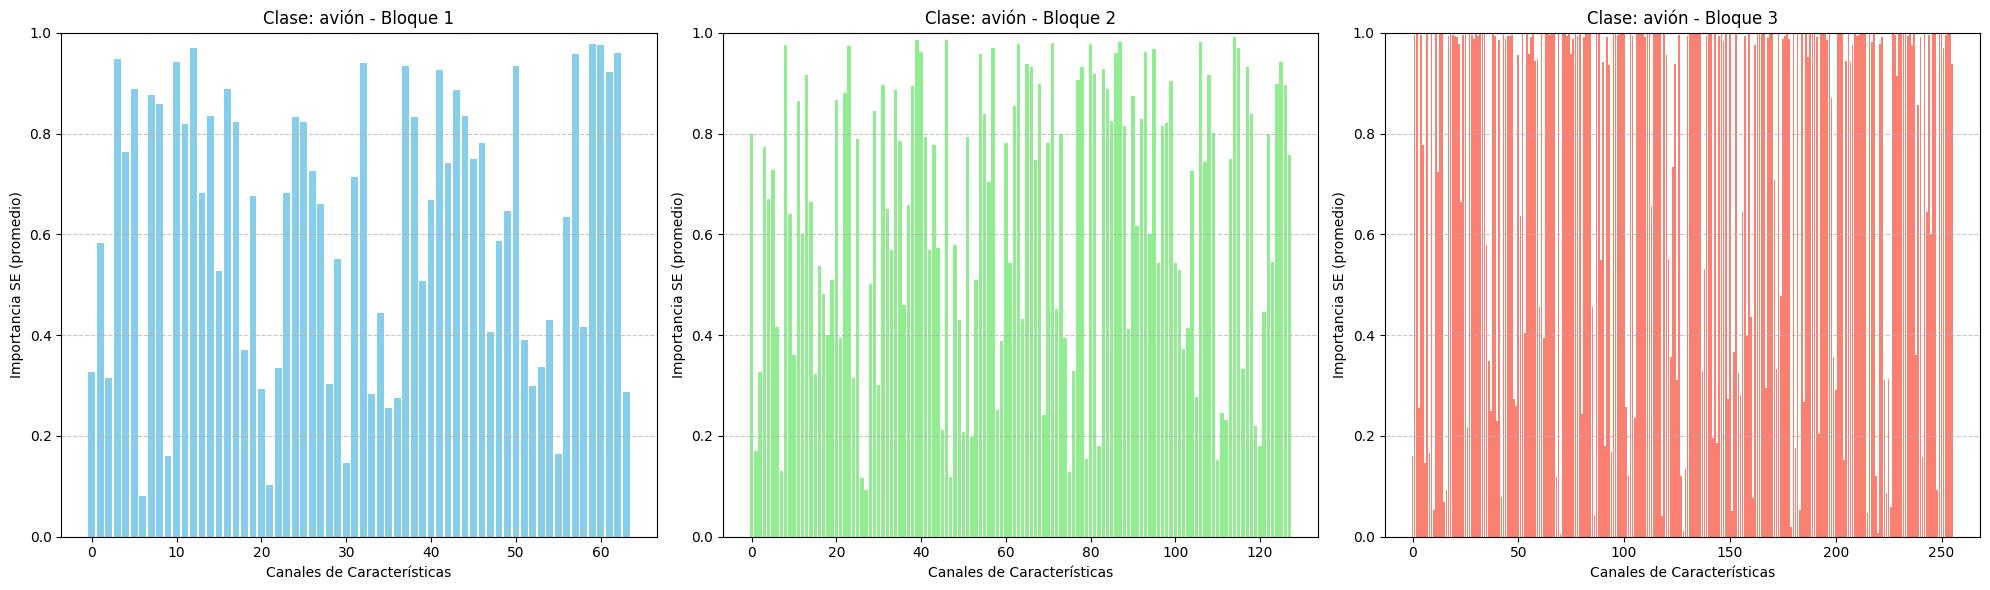

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


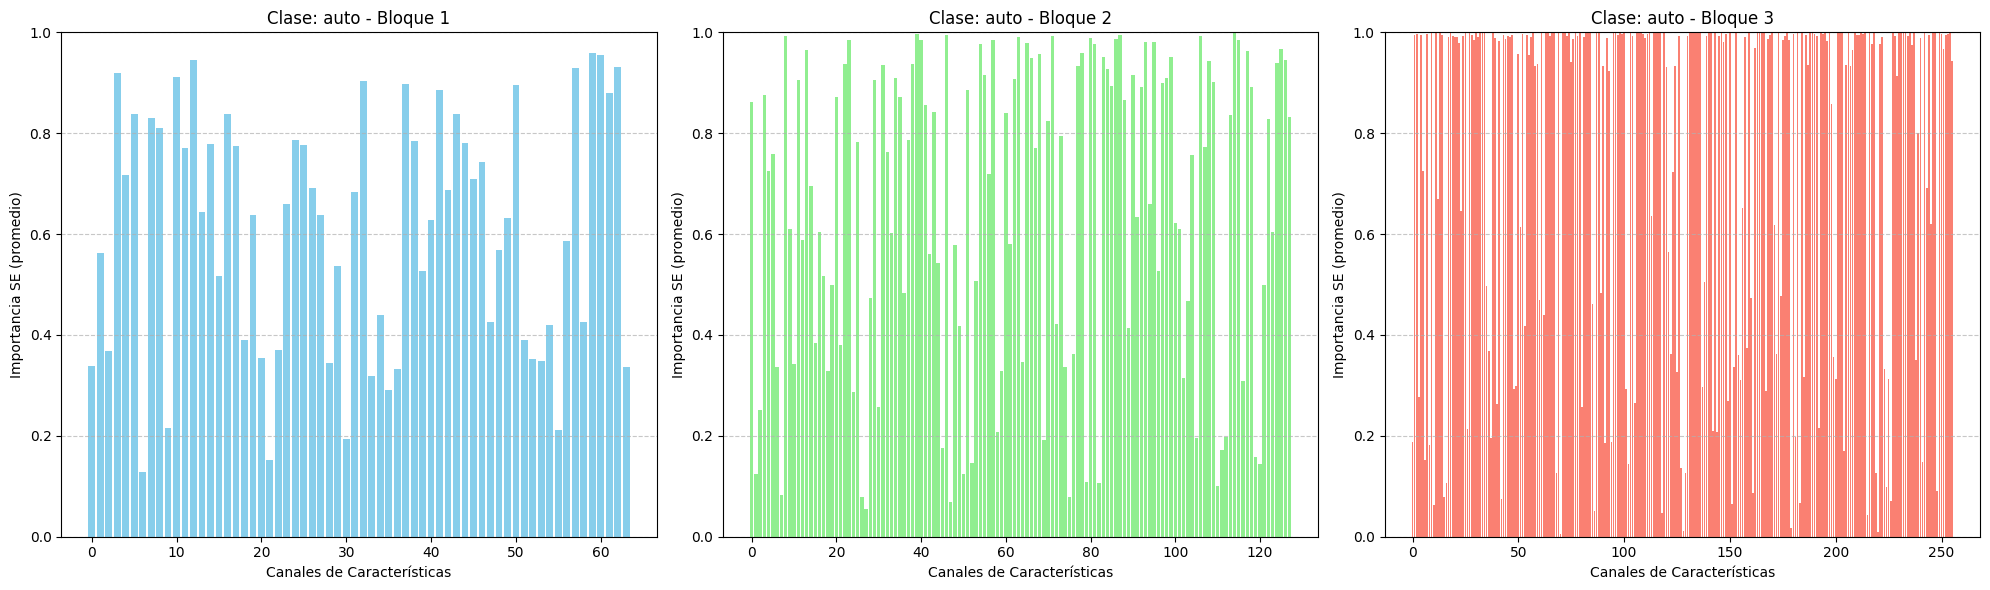

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


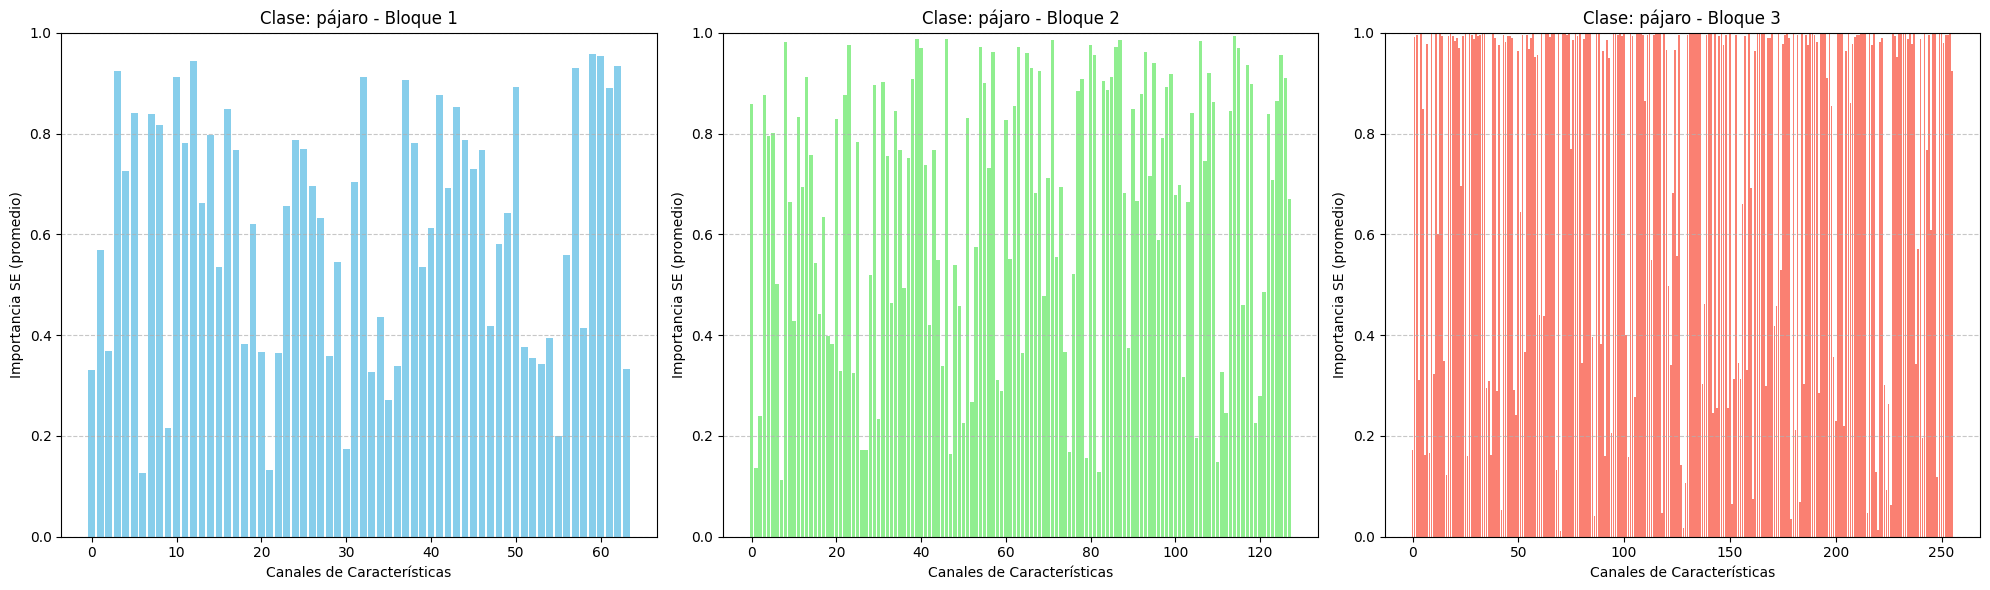

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


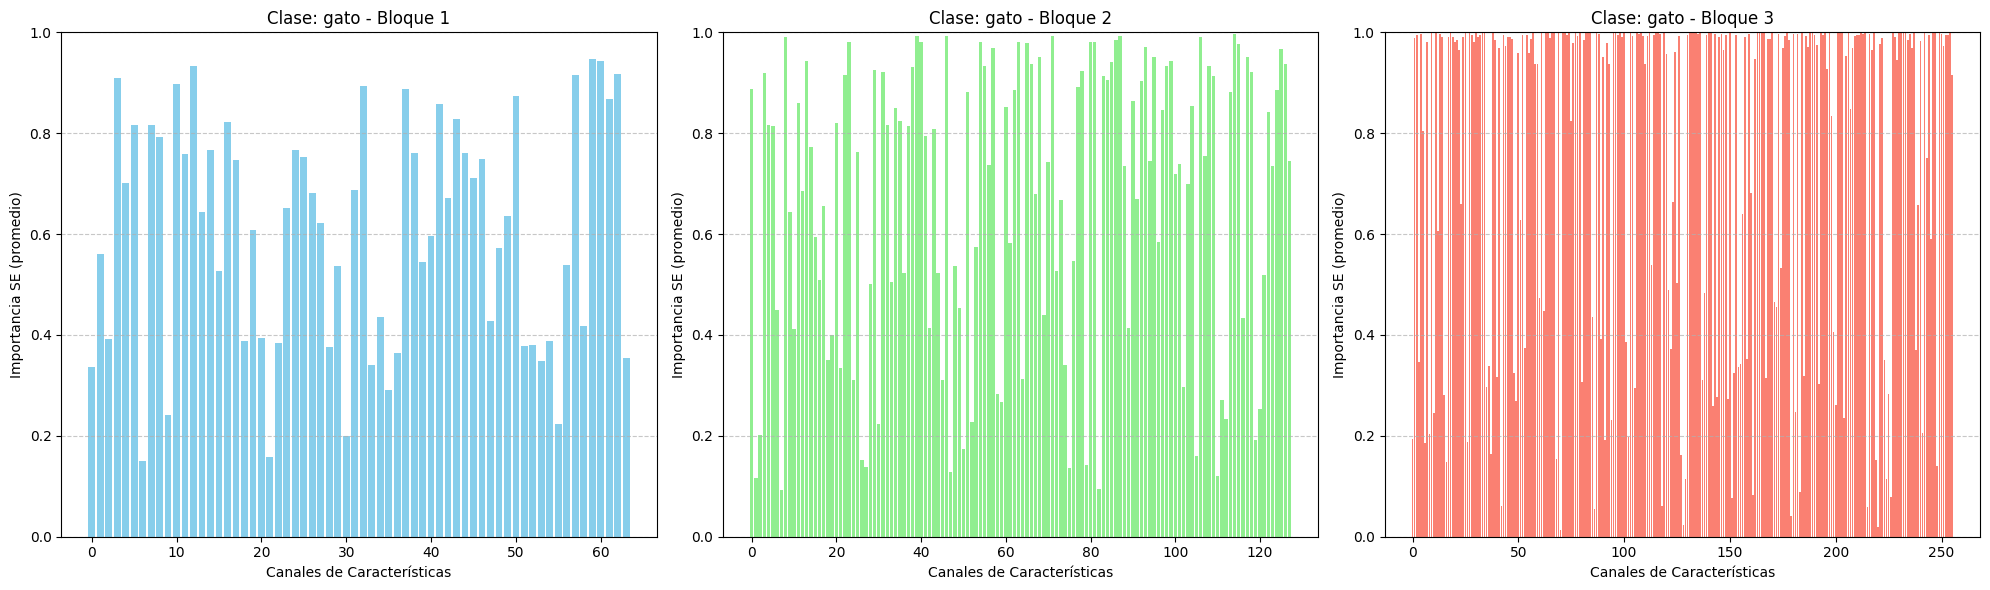

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


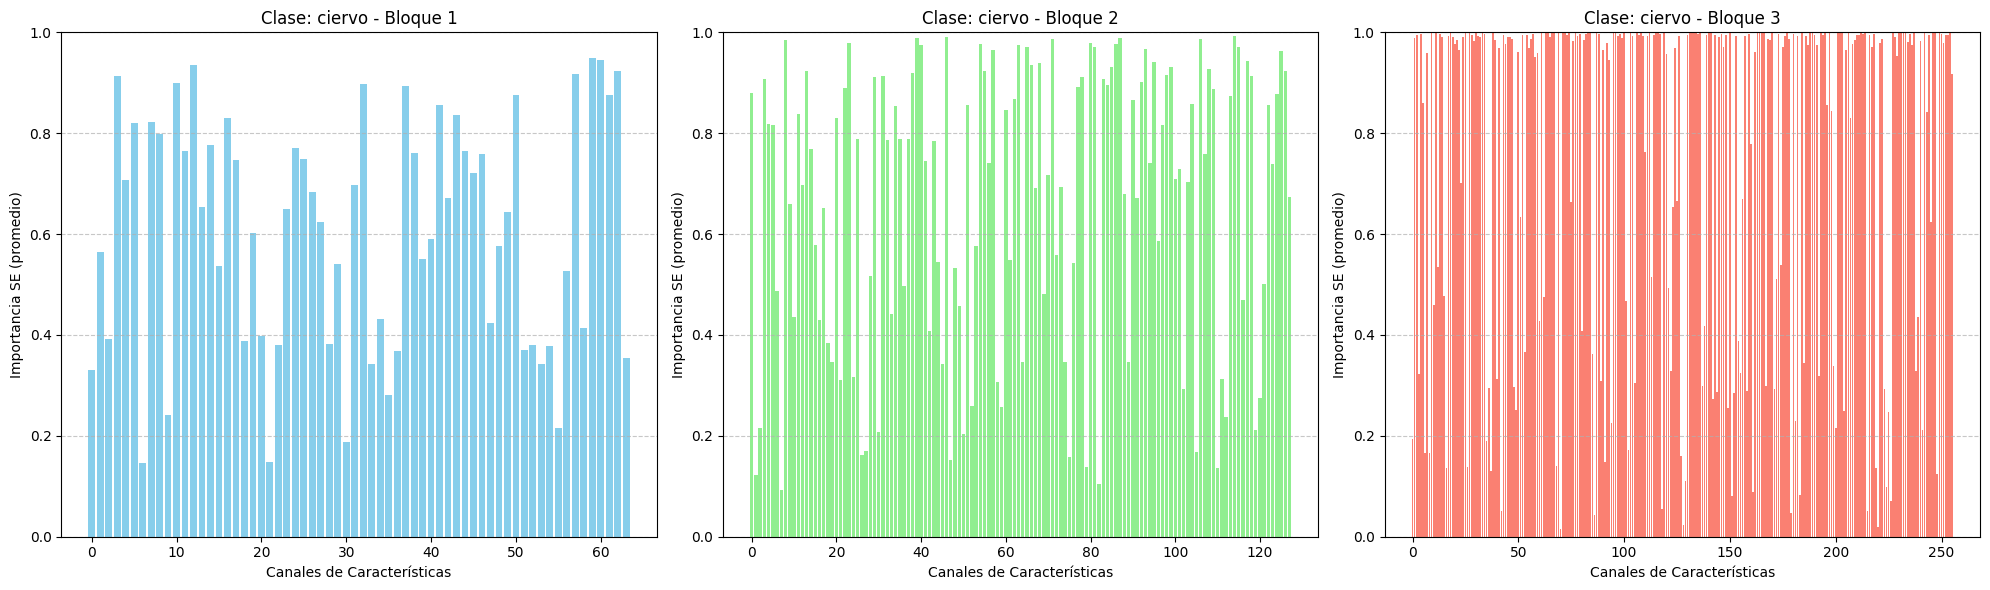

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


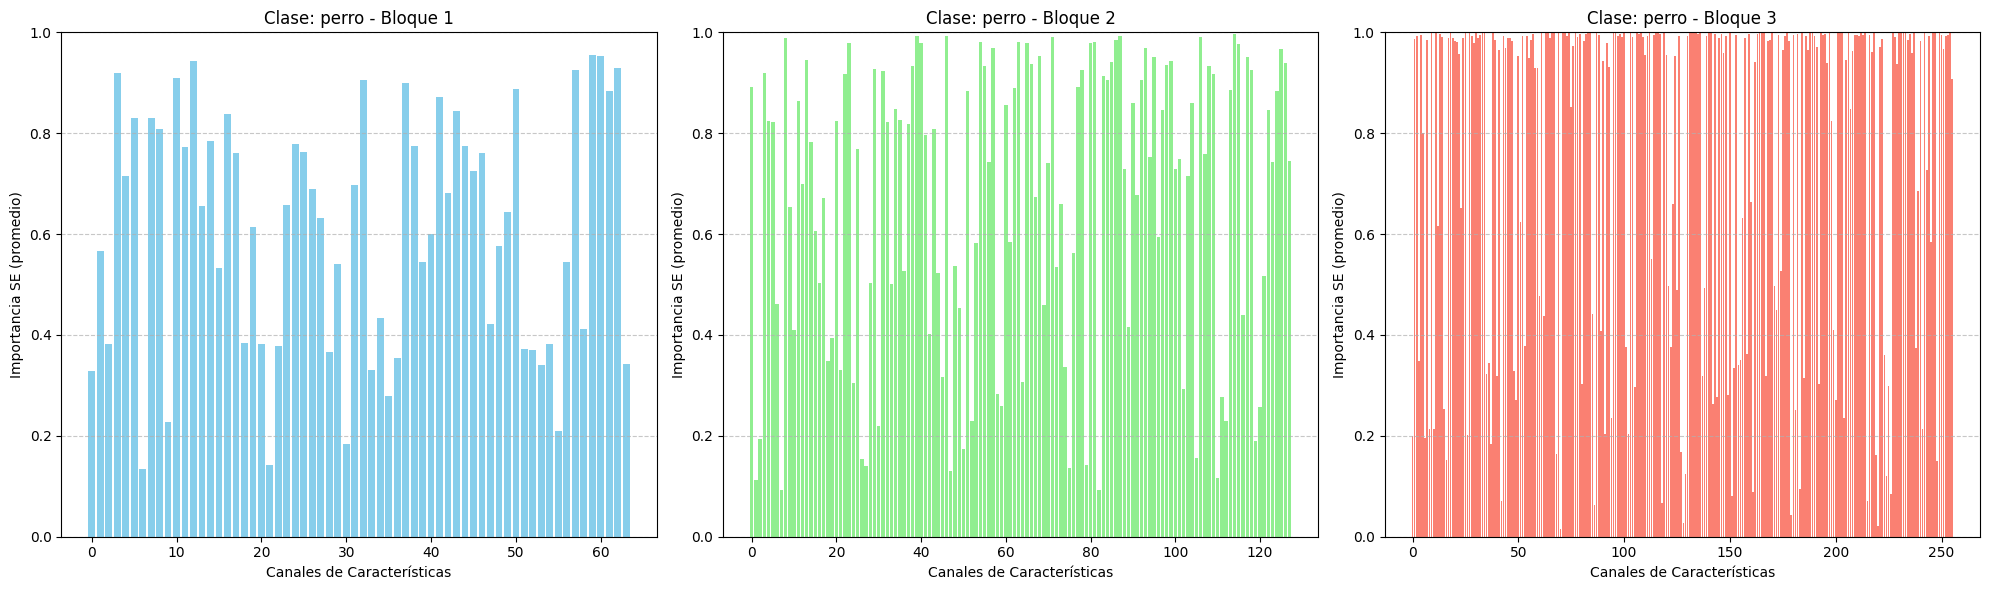

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


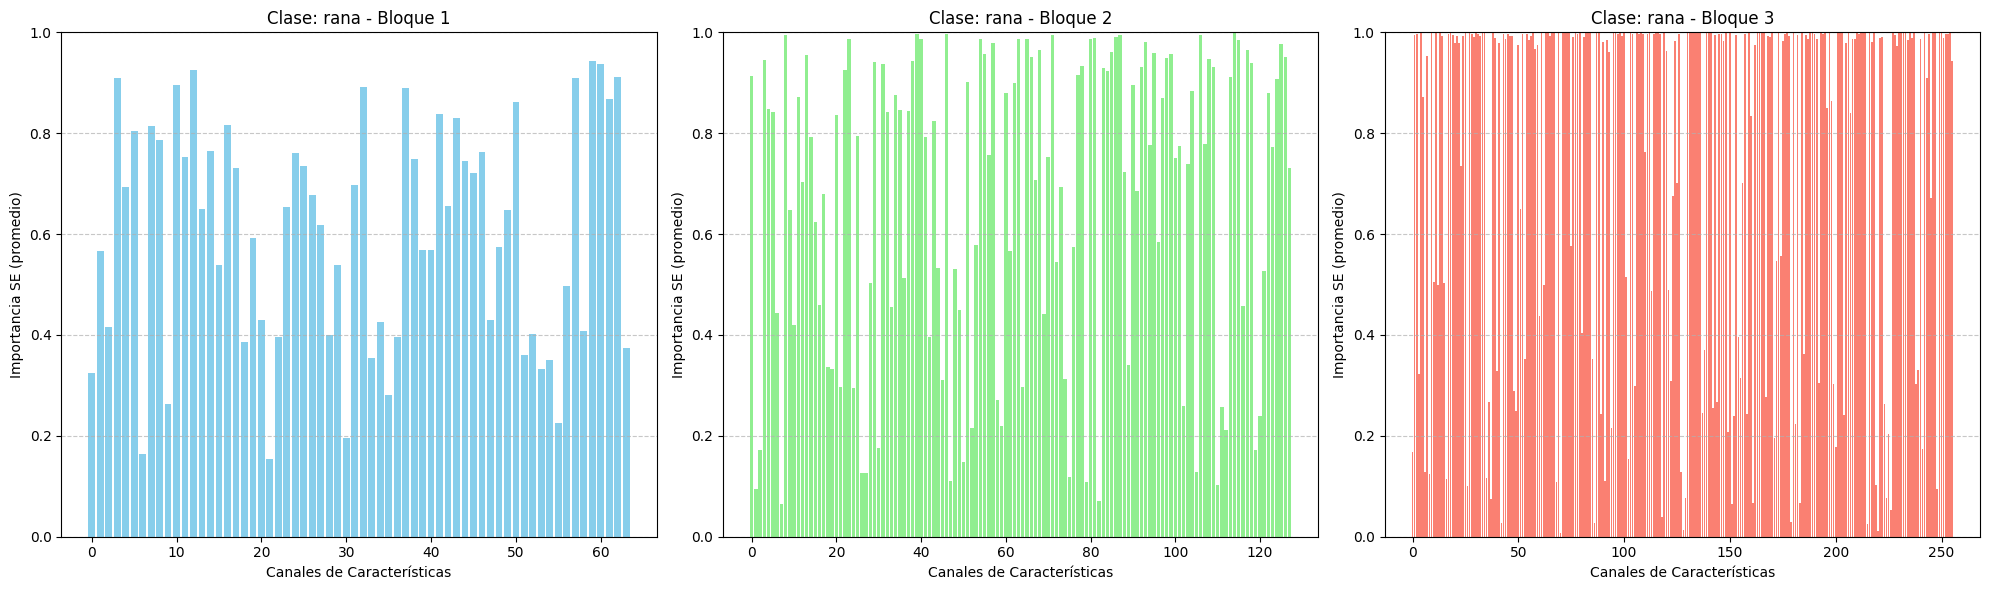

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


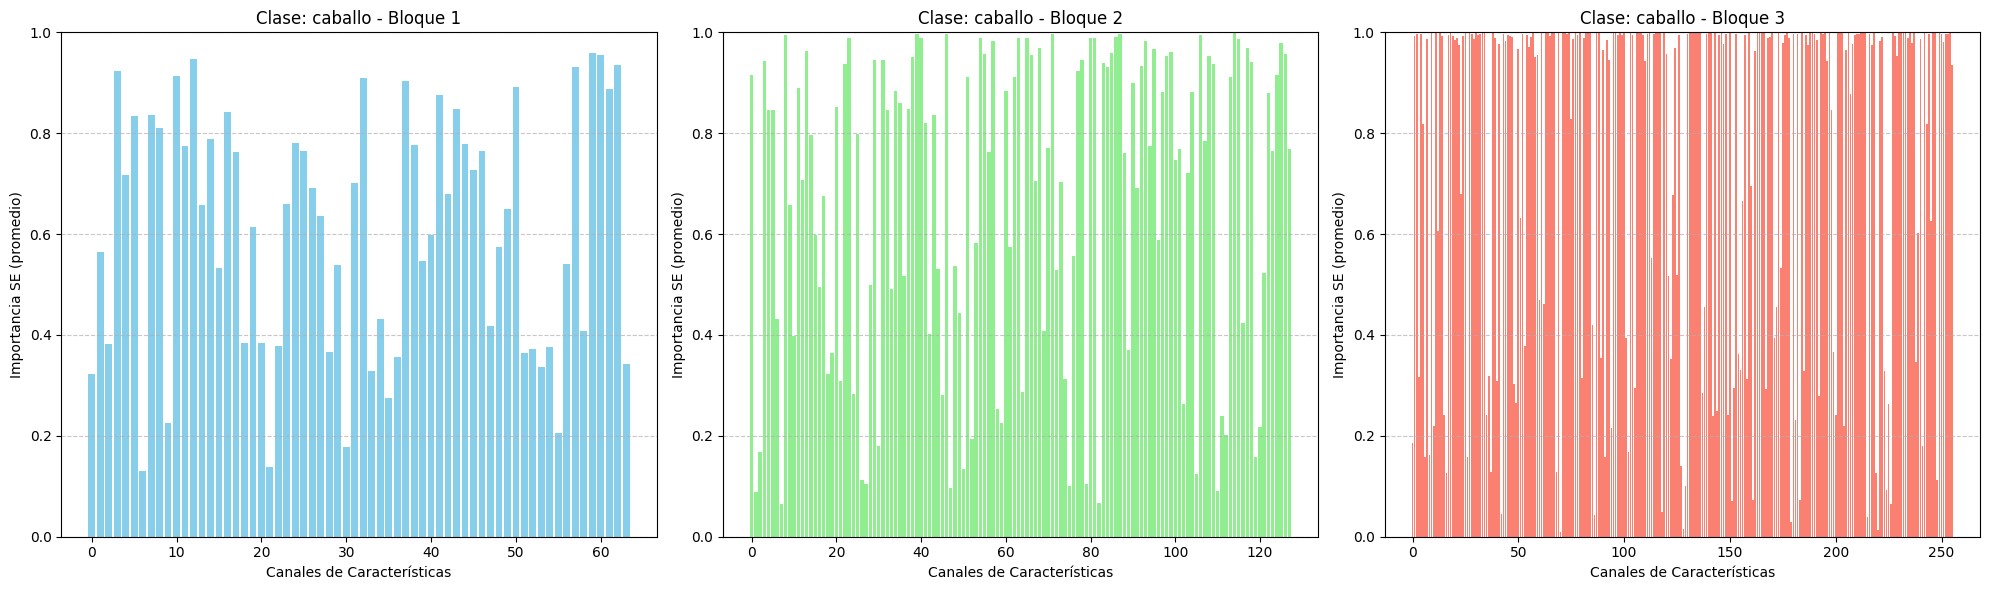

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


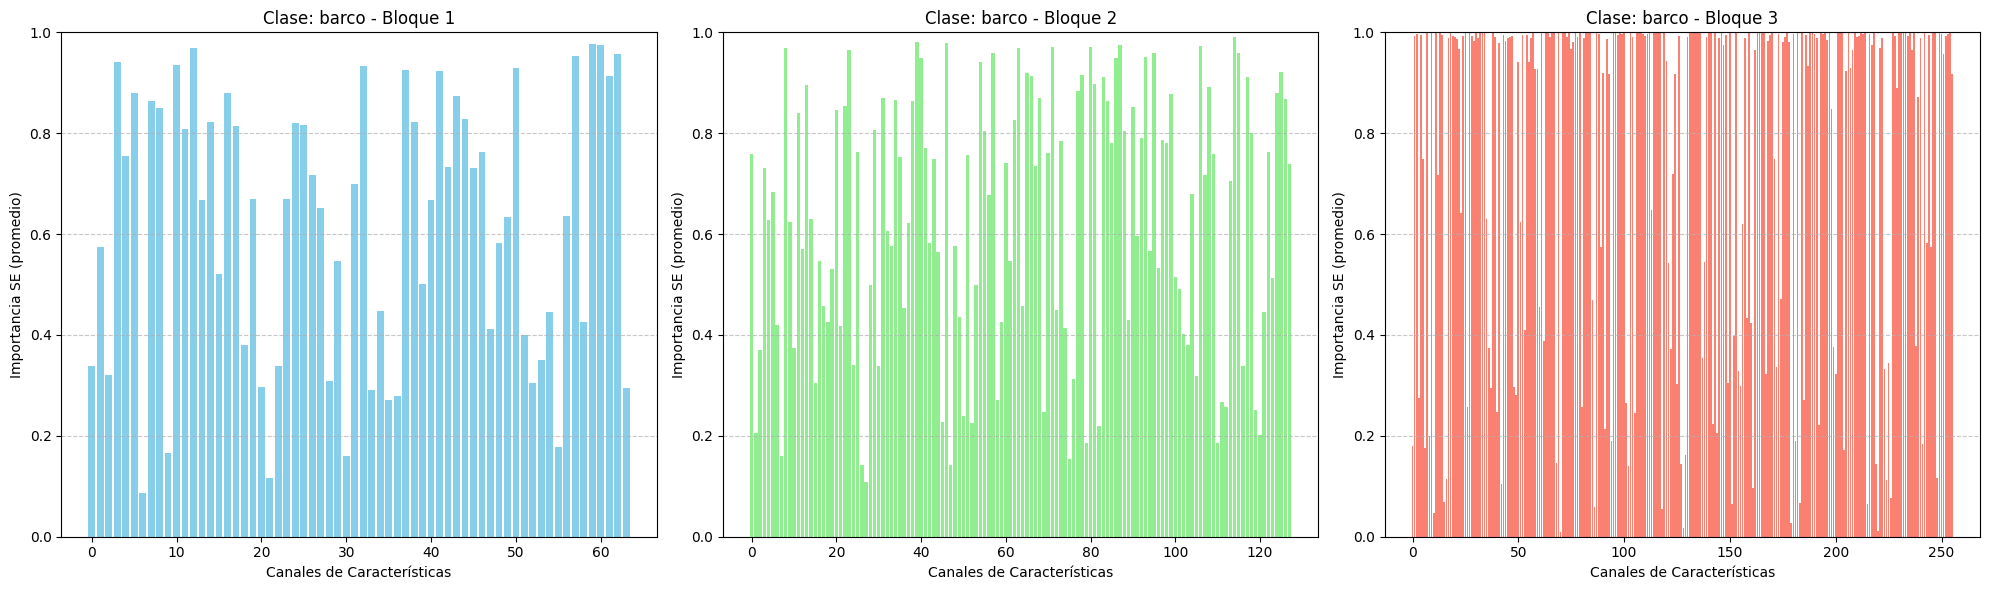

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


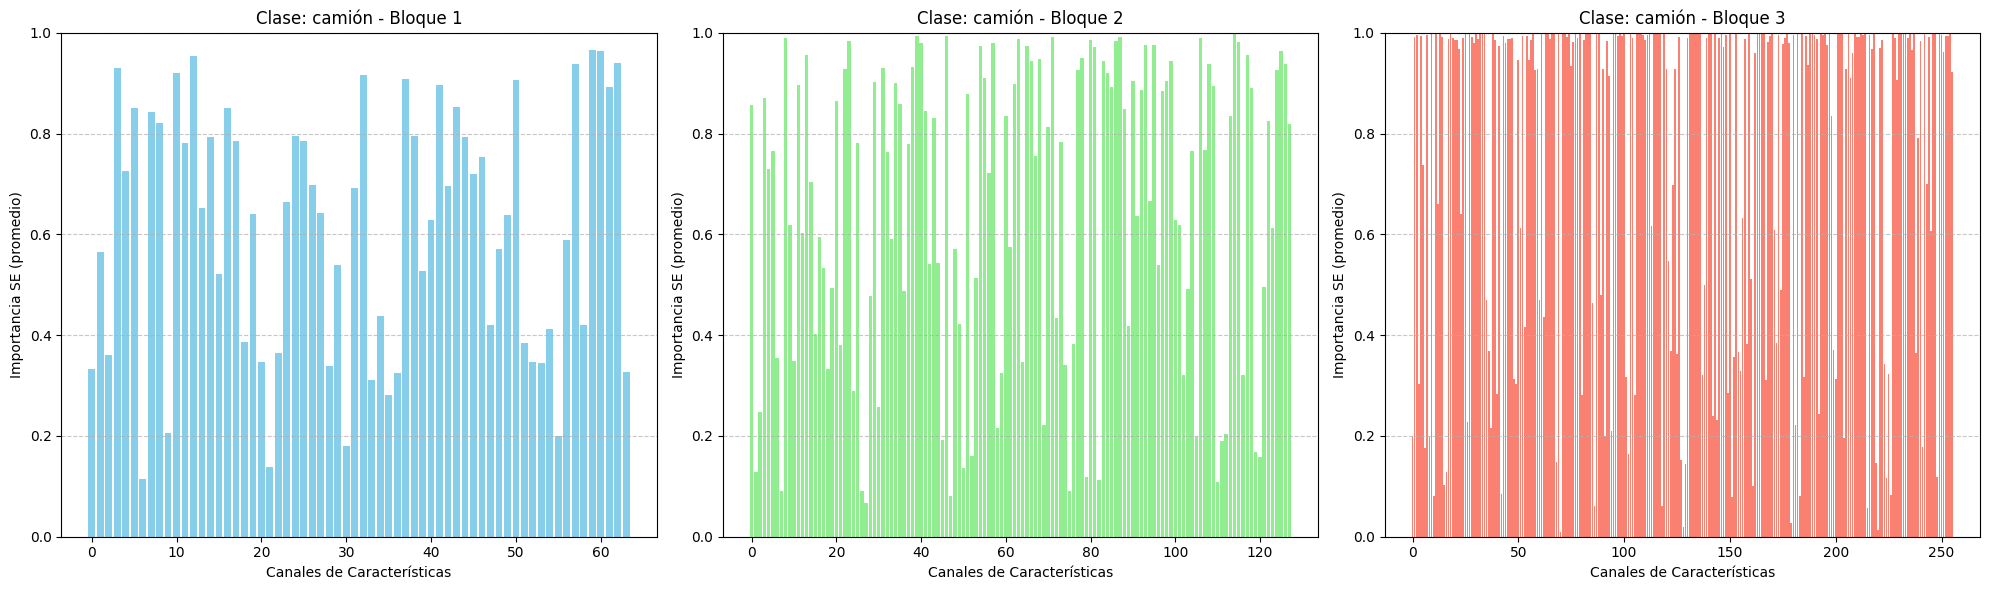

In [6]:
# Visualizar los patrones promedio y desviación estándar por clase
analyze_all_classes_detailed()